In [1]:
%matplotlib inline

In [2]:
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

## Introduction

Labs 9 and 10 were all about linear models, specifically linear and logistic regression. We learned how to build and interpret multivariate models by using domain knowledge, comparing the predicted and actual values of the coefficients and the credible intervals, and looking at residuals. We also applied transformations to make the models perform better and increase interpretability.

Using the techniques covered during Modules 9 and 10 (lectures, labs, course notes), **build, describe, and use** a linear regression model that estimates the target variable `mpg` for the accompanying auto data set. You may use other techniques you know but you must at least use the techniques described in class and call out and describe anything "extra" that you do and why.

Do **not** use any feature selection techniques or anything other than linear regression. Follow the method described in class.

The instructions say build, **describe, and use**. You must describe all aspects of your final model (all the parameters and metrics) and use it to predict one value as described in the course notes.

## Table of Contents

* [1.1 - ETL](#etl)
* [1.2 - EDA](#eda)
* [1.3 - Build the model](#build)
* [1.4 - Describe the model](#describe)
* [1.5 - Use the model](#use)

<a id="etl"></a>

## 1.1 - ETL

Prior to working in this document, the .txt file was converted to a .csv file using Microsoft Excel. 

After opening the original .txt file in Excel and separating each of the columns correctly, a new .csv file was created called `auto.csv` that contains all of the original data.

Now, we can load our data into our notebook using pandas.

Imports:

In [3]:
import pandas as pd

Use pandas to read in the .csv file into a DataFrame called `data`.

In [4]:
data = pd.read_csv('auto.csv', header = None)

Next, let's give each of our columns an appropriate header.

In [5]:
data.columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "car_name"]

We know from our supporting `auto_names.txt` file that our DataFrame should have 398 instances with 9 attributes that are as follows:

```
    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)
```


First, let's view the structure of our DataFrame to confirm that we have 398 instances of 9 variables.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      398 non-null object
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null int64
car_name        398 non-null object
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


The DataFrame has 9 columns and there are 398 records (or observations) for each variable, so we know that there are no blatent missing values. We will continue to check for this as we examine our data. 

We also need to check that each of our variables is the correct data type. The following variables need changes:
    
    - `horsepower` should be float64
    - `weight` should be float64
    
When we try and make `horsepower` into a float, we get an error. When we take a closer look into `horsepower` and read out .txt file, we see that there are 6 instances where horsepower is unknown and has a value of '?'. So, we need to decide how to handle this missing values. Since our DataFrame has 398 observations, for this exercise, we will drop the three observations where horsepower is unknown.

Remove the 6 rows where `horsepower` has the value of '?'.

In [7]:
data = data[data['horsepower'] != '?']

In [8]:
data = data.reset_index()

Let's make sure that our DataFrame now has 392 entries.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
index           392 non-null int64
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null object
weight          392 non-null int64
acceleration    392 non-null float64
model_year      392 non-null int64
origin          392 non-null int64
car_name        392 non-null object
dtypes: float64(3), int64(5), object(2)
memory usage: 30.8+ KB


Now that we have removed the missing values from `horsepower`, we can change `horsepower` and `weight` to their correct data types.

In [10]:
data['horsepower'] = data['horsepower'].astype(float)
data['weight'] = data['weight'].astype(float)

Finally, let's check that each of our variables has the correct data type and view the first few rows of the DataFrame.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 10 columns):
index           392 non-null int64
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
model_year      392 non-null int64
origin          392 non-null int64
car_name        392 non-null object
dtypes: float64(5), int64(4), object(1)
memory usage: 30.8+ KB


In [12]:
data.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu"""
1,1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320"""
2,2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite"""
3,3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst"""
4,4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino"""


We notice from a quick view of our data and from our data dictionary in the `auto_names.txt` file that the variable `car_name` may be difficult to for us to use; we are told in our data dictionary that `car_name` is a string that is unique for each instance. So, we will want to use some caution and explore this variable closely in EDA.

Now, we are ready to begin EDA.

<a id="eda"></a>

## 1.2 - EDA

We will begin our exploratory data analysis by examining each single variable individually.

### Single Variable Exploration

The file `auto.csv` contains data about different vehicles.

The variables are:

* [mpg](#mpg)
* [cylinders](#cylinders)
* [displacement](#displacement)
* [horsepower](#horsepower)
* [weight](#weight)
* [acceleration](#acceleration)
* [model_year](#model_year)
* [origin](#origin)
* [car_name](#car_name)

Our goal is to be able to find relationships between a car's `mpg` and the other variables. EDA is just the first step in this process. We will start by looking for patterns in each individual variable.

<a id="mpg"></a>

### mpg

We know that `mpg` is a continuous variable and will also be our predicted variable. From prior knowledge, we know that mpg must be greater than 0 and is likely not greater than 50 (while this could be possible for some smaller diesel cars). 

Let's first take a look at the summary statistics for `mpg` to get a sense for its range and to see if there are any data entry errors or another unexpected values.

In [13]:
data.mpg.describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The minimum `mpg` is $9$ while the maximum is $46.6$. These are both within ranges that are reasonable for different types of vehicles. The median (50%) is also slightly lower than the mean which suggests that there is a leftward skew.

Since `mpg` is numerical, we can also view a histogram of the data.

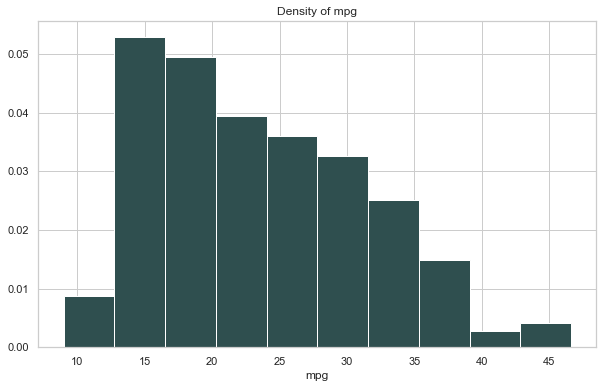

In [14]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.mpg, density = True, color="darkslategray")
axes.set_title("Density of mpg")
axes.set_xlabel("mpg")

plt.show()
plt.close()

We notice that besides our first and last bins, each sequential bin has a smaller count than the previous bin.

Given the shape of the data, we may need to look at `mpg` on a log scale.

<a id="cylinders"></a>

### cylinders

Cylinders indicates the number of cylinders in the engine of the vehicle. Typically, a vehicle with more cylinders has more power, and vehicles with less cylinders have better fuel economy.

In our data dictionary, `cylinders` is indicated as a multi-valued discrete variable. So, we can perform numerical calculations on the data, but we can also view the variable as categories, since it is multi-valued discrete.

We will first take a quick look at the descriptive statistics. 

In [15]:
data.cylinders.describe()

count    392.000000
mean       5.471939
std        1.705783
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

We see that the minimum number of cylinders is $3$ while the maximum is $8$.

Next, let's look at the proportions for each number of cylinders.

In [16]:
pd.DataFrame(data["cylinders"].value_counts(normalize = True))

,cylinders
4,0.507653
8,0.262755
6,0.211735
3,0.010204
5,0.007653


Over $50 \%$ of the vehicles in our dataset have $4$ cylinder engines while approximately $26 \%$ of vehicles have $8$ cylinder engines. We can also view this information as a histogram.

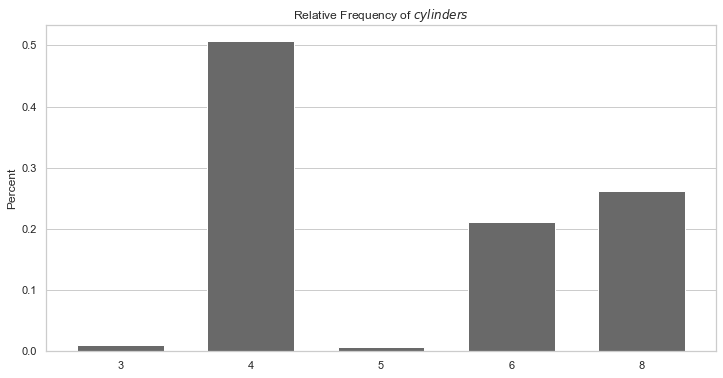

In [17]:
counts = data["cylinders"].value_counts().sort_index()
proportions = data["cylinders"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xticks([0, 1, 2, 3, 4])
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of $cylinders$")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

We see that $3$ cylinder and $5$ cylinder engines are relatively uncommon; this is consistent with the knowledge that these engines are harder to balance than even-number cylinder engines. For this reason, many car manufacturers have stopped production of vehicles with these size engines.

<a id="displacement"></a>

### displacement

Displacement is the measure of the cylinlder volume that is swept by all of the pistons of a piston engine, excluding combustion chambers. So, `displacement` is commonly used as an expression of an engine's size and by extension, as a loose indicator of the power that an engine might be capable of producing and the amount of fuel it should be expected to consume. Therefore, we would expect that as `displacement` increases, `mpg` would decrease (and vice versa).

The calculation for displacement includes multiplying by the number of cylinders. We should be mindful of this likely correlation between these two variables as we continue through EDA and creating our linear model.

Displacement is a continuous (float) variable. So, we can look at the descriptive statistics.

In [18]:
data.displacement.describe()

count    392.000000
mean     194.411990
std      104.644004
min       68.000000
25%      105.000000
50%      151.000000
75%      275.750000
max      455.000000
Name: displacement, dtype: float64

We see that we have a minimum value of $68$. This value is positive and greater than $0$ which is what we would expect. We also note the high standard deviation.

Next, view the histogram of the density of `displacement`.

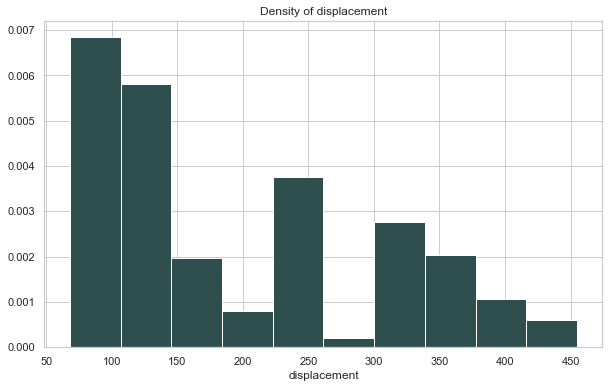

In [19]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.displacement, density = True, color="darkslategray")
axes.set_title("Density of displacement")
axes.set_xlabel("displacement")

plt.show()
plt.close()

The shape of the density histogram of displacement is irregular; some of the middle bins have significantly smaller densities that we might expect based on the surrounding bins. However, if we consider what we have mentioned earlier that displacement is calculated by multiplying by the number of cylinders, this makes more sense. 

We know that approximately $50 \%$ of the vehicles have 4-cylinder engines. So, it makes sense that the majority of the displacements are on the smaller end since we multiply by the number of cylinders. Then, the majority of vehicles have either 8-cylinder or 6-cylinder engines. So, we would also expect to have an array of higher displacements in two different peaks corresponding to each of these values. Finally, we have very few vehicles with 5-cylinder engines and no vehicles with 7-cylinders, so we also expect to have less displacements around where these two values would be. So, we can see the possible correlation between cylinders already in our chart of its density, and therefore, we should be mindful of this during our model building.

<a id="horsepower"></a>

### horsepower

Horsepower is the measurement for the power than an engine can put out. In strictly mathematical terms, it is the power needed to move 500 pounds one foot in one second.

Since horsepower is the measurement of power, as `horsepower` increases, we expect `mpg` to decrease.

Let's look at the descriptive statistics for `horsepower`.

In [20]:
data.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

We see that our minimum value of $46$ is greater than $0$. Since the median is less than the mean, we also expect to see a left-skew to the distribution of horsepower. 

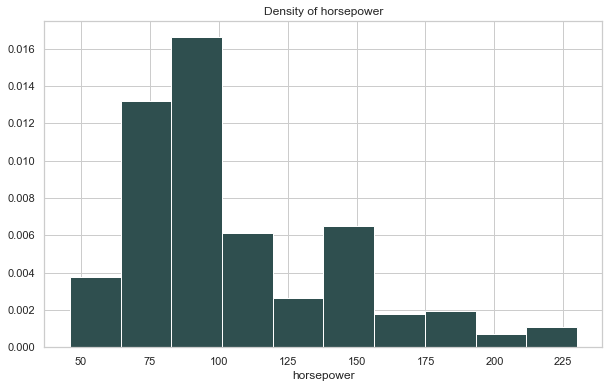

In [21]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.horsepower, density = True, color="darkslategray")
axes.set_title("Density of horsepower")
axes.set_xlabel("horsepower")

plt.show()
plt.close()

We do see the anticipated left-skew of the distribution.

<a id="weight"></a>

### weight

Weight is the weight of the vehicle. Vehicles with greater weights get less mpg.

Let's take a look at the descriptive statistics for `weight`.

In [22]:
data.weight.describe()

count     392.000000
mean     2977.584184
std       849.402560
min      1613.000000
25%      2225.250000
50%      2803.500000
75%      3614.750000
max      5140.000000
Name: weight, dtype: float64

By looking at these statistics, we notice that the median of $2803.5$ is less than the mean of $2977.6$. Therefore, we expect to see a slight left skewness to the distribution.

Now, let's create a histogram of the distribution.

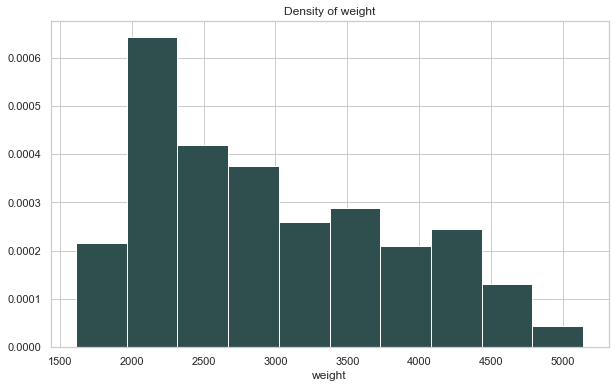

In [23]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.weight, density = True, color="darkslategray")
axes.set_title("Density of weight")
axes.set_xlabel("weight")

plt.show()
plt.close()

We indeed see the left-skew of the distribution of `weight`. 

<a id="acceleration"></a>

### acceleration

Acceleration is the rate of change of velocity with respect to time.

Drivers who utilize these greater accelerations to frequently speed up and break quickly should get poorer `mpg`. However, just because a car has the capability to undergo greater accelerations doesn't necessarily mean that the driver will do what we described above and be an "aggressive driver".

First, let's look at the descriptive statistics for `acceleration`, which is a numerical variable.

In [24]:
data.acceleration.describe()

count    392.000000
mean      15.541327
std        2.758864
min        8.000000
25%       13.775000
50%       15.500000
75%       17.025000
max       24.800000
Name: acceleration, dtype: float64

The median of $15.5$ is slightly less than the mean of $15.54$. So, we expect to see a slight left-skew to the distribution.

Now let's plot the density histogram of `acceleration`.

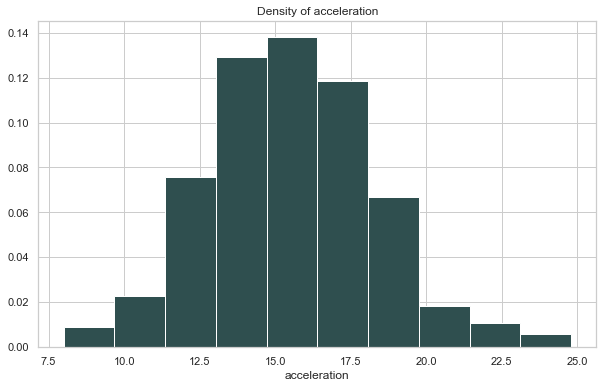

In [25]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data.acceleration, density = True, color="darkslategray")
axes.set_title("Density of acceleration")
axes.set_xlabel("acceleration")

plt.show()
plt.close()

We can see the slight left-skew to the distribution. A normal distribution may represent this variable.

<a id="model_year"></a>

### model_year

The `model_year` is the year in which the model was released. 

This is a multi-valued discrete variable. So, while it is an integer and we can perform calculations on it, we could also consider this variable as categorical with each year being its own category.

We will start by looking at the descriptive statistics for `model_year`.

In [26]:
data.model_year.describe()

count    392.000000
mean      75.979592
std        3.683737
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: model_year, dtype: float64

The minimum `model_year` is $70$ while the maximum `model_year` is $82$. 

Next, let's look at the normalized counts of `model_year`.

In [27]:
pd.DataFrame(data.model_year.value_counts(normalize = True))

,model_year
73,0.102041
78,0.091837
76,0.086735
82,0.076531
75,0.076531
79,0.073980
70,0.073980
81,0.071429
77,0.071429
72,0.071429


From the output above, we see that approximately $10.2 \%$ of the vehicles in this dataset have a `model_year` of $73$. Contrastingly, only about $6.6 \%$ of vehicles have a `model_year` of $74$.

Now, let's view a histogram of the relative frequencies of `model_year`.

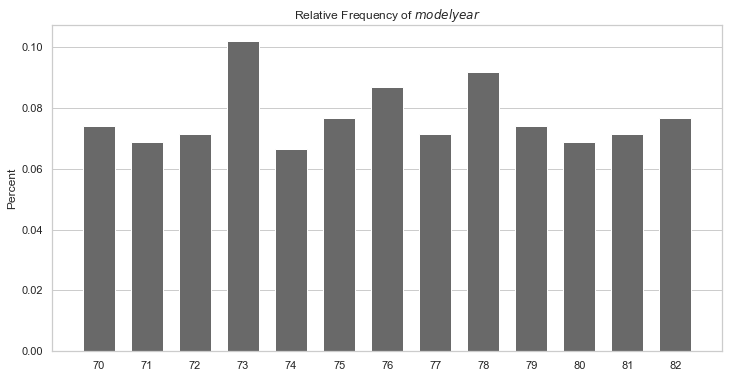

In [28]:
counts = data["model_year"].value_counts().sort_index()
proportions = data["model_year"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of $model year$")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

There are a few model years that have more vehicles in our dataset (73, 76, 78 in particular). However, the remaining years still have around $7 \%$ of the data.

<a id="origin"></a>

### origin

Unfortunately, we don't know much about origin from our support .txt file. All that we are given is that it is multi-value discrete. This variable will most likely need to be viewed as categorical, but we can run the descriptive statistics first.

View descriptive statistics:

In [29]:
data.origin.describe()

count    392.000000
mean       1.576531
std        0.805518
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: origin, dtype: float64

From these values, we see that `origin` take on the values of 1, 2, and 3. 

Now, let's take a look at the normalized counts of `origin`.

In [30]:
pd.DataFrame(data.origin.value_counts(normalize = True))

,origin
1,0.625000
3,0.201531
2,0.173469


This tells us that $62.5 \%$ of the vehicles in our dataset have an origin of $1$, $20.2 \%$ have an origin of $3$ and $17.3 \%$ have an origin of $2$.

We can also view this information in a chart of relative frequencies.

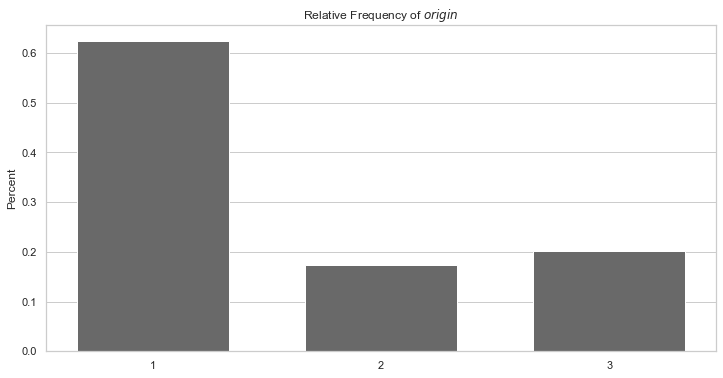

In [31]:
counts = data["origin"].value_counts().sort_index()
proportions = data["origin"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(12, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xticks([0, 1, 2])
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of $origin$")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

It is easy to see from this this chart that the majority of vehicles in this dataset have an origin value of $1$.

<a id="car_name"></a>

### car_name

The `car_name` is a String (text) variable that is the name of the vehicle's make and model.

In [32]:
pd.DataFrame(data.car_name.value_counts(normalize = True))

,car_name
"""amc matador""",0.012755
"""ford pinto""",0.012755
"""toyota corolla""",0.012755
"""toyota corona""",0.010204
"""peugeot 504""",0.010204
...,...
"""ford mustang""",0.002551
"""datsun 510 (sw)""",0.002551
"""chevrolet bel air""",0.002551
"""datsun 810""",0.002551


Since the DataFrame has 301 rows, we know that there are 301 unique values of `car_name` in our dataset. We also know that this is spelling and case sensitive, so if the same vehicle is in our dataset twice and is presented slightly differently (for example "pontiac j2000 se hatback" and "pontiac se hatchback" will appear separately).

Due to the nature of the variable, it likely won't be super useful to use in our model but would be helpful if investigating specific instances of our dataset.

### Multiple Variable Exploration
### mpg vs. ???

Now, we will explore the relationship between `mpg`, which is the variable of main interest, and the rest of the variables. 

We will explore:

* [mpg vs. cylinders](#mpg_cylinders)
* [mpg vs. displacement](#mpg_displacement)
* [mpg vs. horsepower](#mpg_horsepower)
* [mpg vs. weight](#mpg_weight)
* [mpg vs. acceleration](#mpg_acceleration)
* [mpg vs. model_year](#mpg_model_year)
* [mpg vs. origin](#mpg_origin)
* [mpg vs. car_name](#mpg_car_name)

We will define some functions which we will use throughout the rest of EDA:

    - correlation
    - multiboxplot

In [33]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r =", stats.pearsonr(data[x], data[y])[0])
    print( "rho =", stats.spearmanr(data[x], data[y])[0])

In [34]:
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))
    
    axes = figure.add_subplot(1, 1, 1)
    
    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    
    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)
    
    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))
    
    plt.show()
    plt.close()

Now, we will begin multiple variable EDA.

<a id="mpg_cylinders"></a>

### mpg vs cylinders

`Cylinders` seems like it could be at least one explanatory variable of `mpg`.  We know from domain knowledge that vehicles with a smaller number of cylinders tend to get better fuel economy or more `mpg`. So, we expect to see some sort of a negative correlation between `cylinders` and `mpg`.

First, let's look at the correlation coefficients.

In [35]:
correlation(data, "cylinders", "mpg")

Correlation coefficients:
r = -0.7776175081260226
rho = -0.8231746391245731


Pearson's correlation coefficient, $r$, is -0.7776 which indicates a strong negative relationship. Spearman's is even higher with a value of -0.8232 which might indicate that there is a slightly stronger negative monotonic relationship.

Let's look at the descriptive statistics for each value of `cylinders`:

In [36]:
grouped = data.groupby( "cylinders")
grouped_y = grouped["mpg"].describe()
print(grouped_y)

           count       mean       std   min    25%    50%    75%   max
cylinders                                                             
3            4.0  20.550000  2.564501  18.0  18.75  20.25  22.05  23.7
4          199.0  29.283920  5.670546  18.0  25.00  28.40  32.95  46.6
5            3.0  27.366667  8.228204  20.3  22.85  25.40  30.90  36.4
6           83.0  19.973494  3.828809  15.0  18.00  19.00  21.00  38.0
8          103.0  14.963107  2.836284   9.0  13.00  14.00  16.00  26.6


First, we notice the small sizes of our data subsets with 3-cylinders and 5-cylinders. So, we should use some caution when drawing conclusions about these particular subsets. We notice that generally, the mean decreases as the number of cylinders increases. This is what we expected it to do. We can also create a visual to help show this relationship.

Let's plot the data using a boxplot:

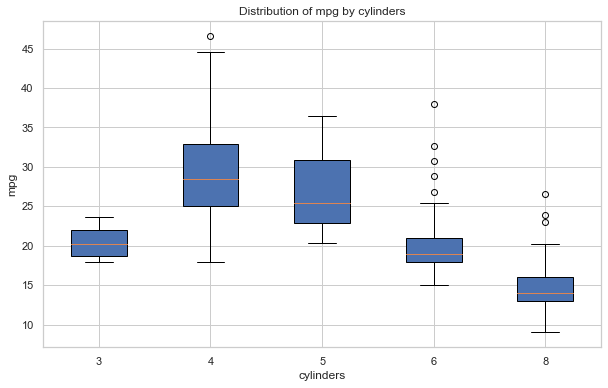

In [37]:
multiboxplot(data, "mpg", "cylinders")

The boxplot visually shows that vehicles with more `cylinders` tend to have lower `mpg`. So, we see the strong, negative relationship between these two variables.

<a id="mpg_displacement"></a>

### mpg vs displacement

We know from domain knowledge that `displacement` is commonly used as an expression of an engine's size and by extension, as a loose indicator of the power that an engine might be capable of producing and the amount of fuel it should be expected to consume. Therefore, we would expect that as `displacement` increases, `mpg` would decrease (and vice versa).

First, let's look at the correlation coefficients.

In [38]:
correlation(data, "displacement", "mpg")

Correlation coefficients:
r = -0.8051269467104578
rho = -0.8552335882841171


Pearson's correlation coefficient, $r$, is -0.8051 which indicates a very strong negative relationship. Spearman's is even higher with a value of -0.8552 which might indicate that there is a slightly stronger negative monotonic relationship.

Let's look at the scatterplot of these two variables:

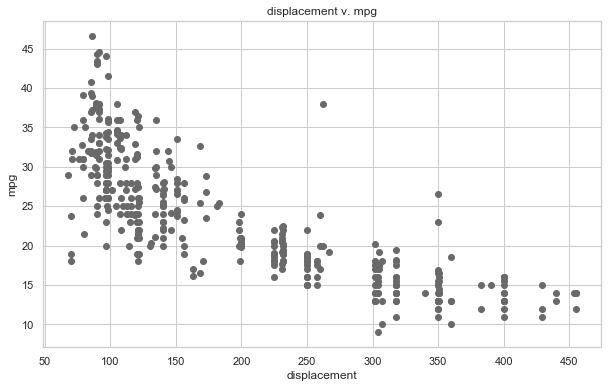

In [39]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data[ "displacement"], data["mpg"], marker="o", color="DimGray")
axes.set_title("displacement v. mpg")
axes.set_xlabel( "displacement")
axes.set_ylabel( "mpg")

plt.show()
plt.close()

We quickly notice the negative trend in the scatterplot. As `displacement` increases, `mpg` decreases. This is what we expected to see. We also notice that there is a higher variance for vehicles with smaller displacements and as displacement increases, our variances appears to decreases. However, our number of data points also decreases, so we should be a little cautious when drawing this conclusion. Finally, we also see some curvature in the scatterplot which tells us that the relationship between `displacement` and `mpg` may not necessarily be linear. So, we may consider using a transformation on `displacement` in our model.

<a id="mpg_horsepower"></a>

### mpg vs horsepower

Since horsepower is the measurement of power, as `horsepower` increases, we expect `mpg` to decrease. So, we expect our correlation coefficients to be strong and negative.

First, let's look at the correlation coefficients.

In [40]:
correlation(data, "horsepower", "mpg")

Correlation coefficients:
r = -0.7784267838977761
rho = -0.8536164024453882


Pearson's correlation coefficient, $r$, is -0.7784 which indicates a strong negative relationship. Spearman's is even higher with a value of -0.8536 which might indicate that there is a slightly stronger negative monotonic relationship.

Let's look at the scatterplot of these two variables:

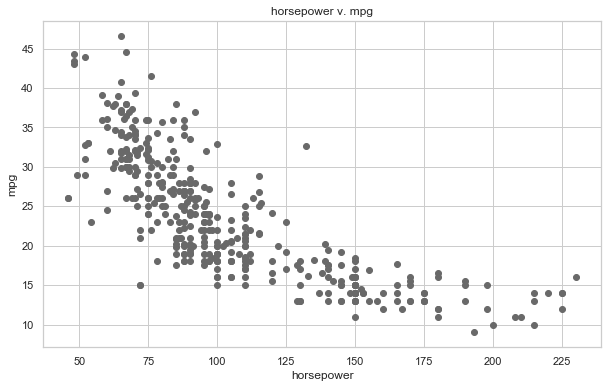

In [41]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data[ "horsepower"], data["mpg"], marker="o", color="DimGray")
axes.set_title("horsepower v. mpg")
axes.set_xlabel( "horsepower")
axes.set_ylabel( "mpg")

plt.show()
plt.close()

We can see the negative trend in the scatterplot. As `horsepower` increases, `mpg` appears to decrease. There is also some curvature in the scatterplot which indicates that the relationship between the two variables is not necessarily linear.

<a id="mpg_weight"></a>

### mpg vs weight

We know that vehicles that weigh more tend to have a poorer fuel economy. So, we expect to have strong, negative correlation coefficients.

In [42]:
correlation(data, "weight", "mpg")

Correlation coefficients:
r = -0.8322442148315755
rho = -0.8755851198739869


Pearson's correlation coefficient, $r$, is -0.8322 which indicates a very strong negative relationship. Spearman's is even higher with a value of -0.8756 which might indicate that there is a slightly stronger negative monotonic relationship. These are the strongest correlations we've seen yet.

Let's look at the scatterplot of these two variables:

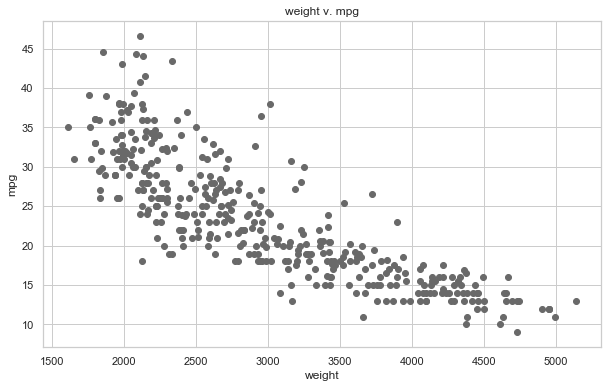

In [43]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data[ "weight"], data["mpg"], marker="o", color="DimGray")
axes.set_title("weight v. mpg")
axes.set_xlabel( "weight")
axes.set_ylabel( "mpg")

plt.show()
plt.close()

Again, we see the negative correlation between `weight` and `mpg` in the scatterplot. There is also slight curvature in the plot, so the relationship between these two variables may not be strictly linear.

<a id="mpg_acceleration"></a>

### mpg vs acceleration

We know that drivers who frequently accelerate and brake (or are aggresive drivers) tend to get poorer `mpg`. However, we also know that not all drivers are aggressive drivers. So, we shouldn't assume that just because a vehicle has greater acceleration that the driver poorly utlizes the increased acceleration.

We will first look at the correlation coefficients.

In [44]:
correlation(data, "acceleration", "mpg")

Correlation coefficients:
r = 0.42332853690278727
rho = 0.4415388584563648


Pearson's correlation coefficient, $r$, is 0.4233 which indicates a weak positive relationship. Spearman's is slightly higher with a value of 0.4415 which also indicates that there is a weak positive monotonic relationship.

Let's look at the scatterplot of these two variables:

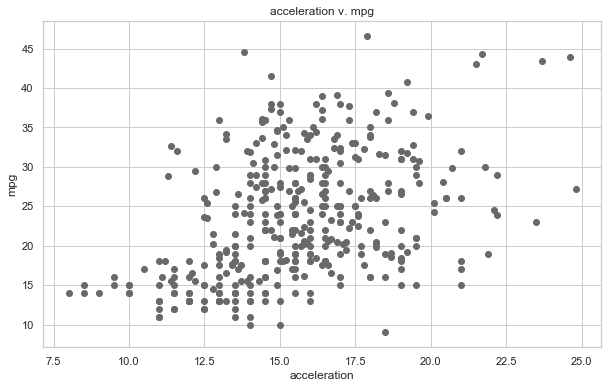

In [45]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data[ "acceleration"], data["mpg"], marker="o", color="DimGray")
axes.set_title("acceleration v. mpg")
axes.set_xlabel( "acceleration")
axes.set_ylabel( "mpg")

plt.show()
plt.close()

We see from the scatterplot that there is not much of a relationship between these two variables. We could possibly say that there is a slight positive trend. However, there does not appear to be a strong relationship between `acceleration` and `mpg`.

<a id="mpg_model_year"></a>

### mpg vs model_year

`model_year` seems like it could be an explanatory variable of `mpg`. It is logical that newer vehicles may have better fuel eceonomy and therefore get more `mpg` than older vehicles. 

Let's first take a look at our correlation coefficients.

In [46]:
correlation(data, "model_year", "mpg")

Correlation coefficients:
r = 0.5805409660907856
rho = 0.5748408744472728


Pearson's correlation coefficient, $r$, is 0.5805 which indicates a positive relationship. Spearman's is slightly lower with a value of 0.5748 which indicates that there is a slightly weaker positive monotonic relationship.

Let's look at the scatterplot and boxplot of these two variables:

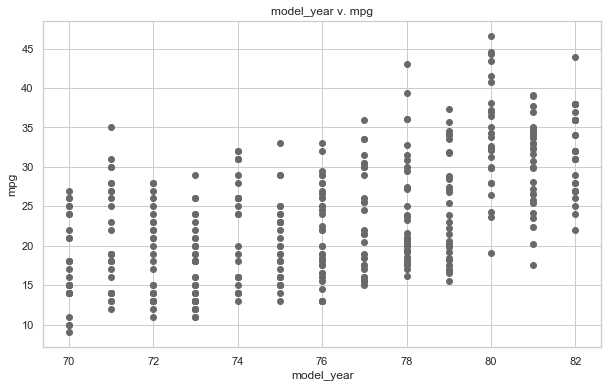

In [47]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.scatter( data[ "model_year"], data["mpg"], marker="o", color="DimGray")
axes.set_title("model_year v. mpg")
axes.set_xlabel( "model_year")
axes.set_ylabel( "mpg")

plt.show()
plt.close()

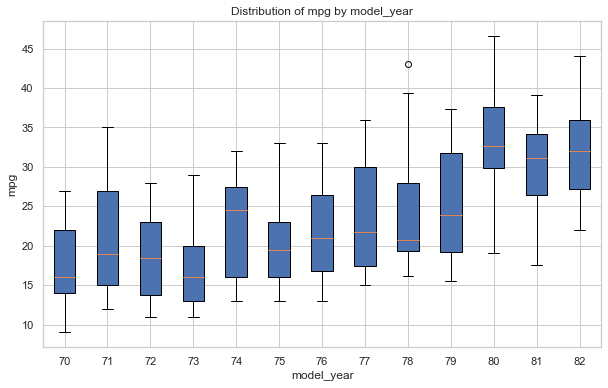

In [48]:
multiboxplot(data, "mpg", "model_year")

We see from the boxplot that as the `model_year` increases, the `mpg` also loosely tends to increase. This relationship is not as strong as some of the other relationships in our pairwise comparisons so far.

<a id="mpg_origin"></a>

### mpg vs origin

Cars from different countries may have different fuel economies. For example, a Volkswagen Jetta has better fuel economy than a Ford Escape. Is this consistent for ALL Volkswagen and Ford vehicles? Most likely not, but it may be the case for enough to be significant to the model.

Let's look at the boxplot of `origin` and `mpg`.

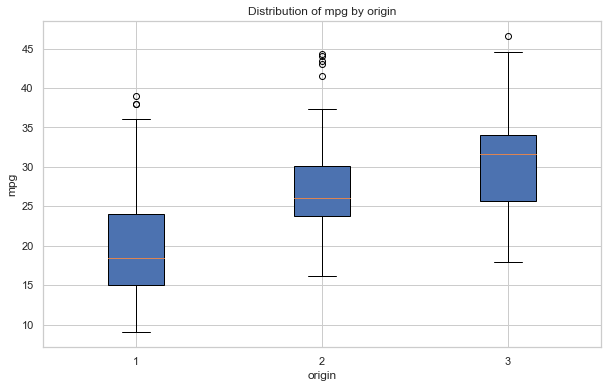

In [49]:
multiboxplot(data, "mpg", "origin")

We see from the boxplot that there appears to be a difference in the distributions of these 3 origins. We can also visualize these distributions using multiple histograms.

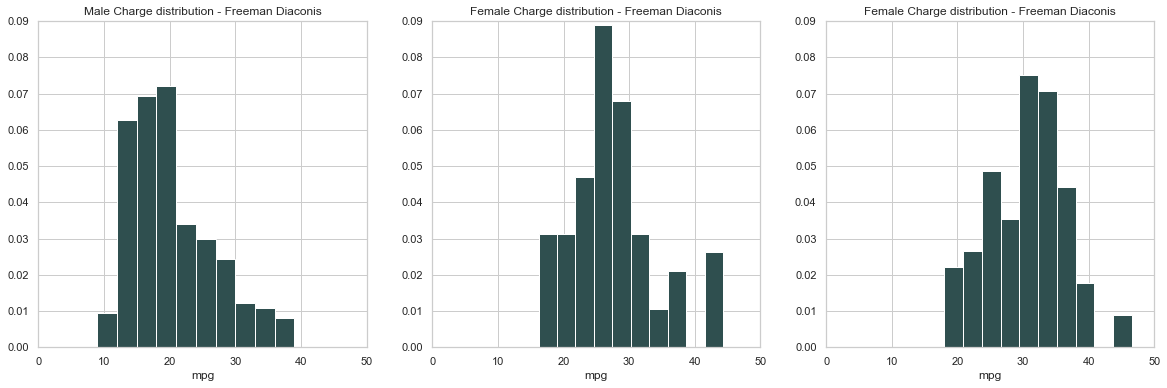

In [50]:
grouped = data.groupby("origin")

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 3, 1)
axes.hist(grouped["mpg"].get_group(1),color="darkslategray",density=True)
axes.set_title("Male Charge distribution - Freeman Diaconis")
axes.set_xlabel("mpg")
axes.set_xlim((0,50))
axes.set_ylim((0,0.09))

axes = figure.add_subplot(1, 3, 2)
axes.hist(grouped["mpg"].get_group(2),color="darkslategray",density=True)
axes.set_title("Female Charge distribution - Freeman Diaconis")
axes.set_xlabel("mpg")
axes.set_xlim((0,50))
axes.set_ylim((0,0.09))

axes = figure.add_subplot(1, 3, 3)
axes.hist(grouped["mpg"].get_group(3),color="darkslategray",density=True)
axes.set_title("Female Charge distribution - Freeman Diaconis")
axes.set_xlabel("mpg")
axes.set_xlim((0,50))
axes.set_ylim((0,0.09))

plt.show()
plt.close()

We can see differences in the shapes of the different distributions as well as the shift in the mean values.

So, we can also take a look at the correlation between `origin` and `mpg`.

In [51]:
correlation(data, "mpg", "origin")

Correlation coefficients:
r = 0.5652087567164608
rho = 0.5804824209039191


Pearson's correlation coefficient, $r$, is 0.5652 which indicates a moderate positive relationship. Spearman's is slightly higher with a value of 0.5805 which also indicates that there is a moderate positive monotonic relationship.

<a id="mpg_car_name"></a>

### mpg vs car_name

Since we have 301 distinct car names in our dataset of 392 instances, it does not make sense to perform a comparison between `car_name` and `mpg`.

`car_name` is best used to investigate any outliers or any other particular instances within our dataset to get more information on the vehicle.

<a id="build"></a>

## 1.3 - Build the model

Now, we will start building a linear model.

First, import `models`.

In [52]:
import models

We can a also remind ourselves of what we named each of the features in our DataFrame.

In [53]:
data.columns

Index(['index', 'mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year', 'origin', 'car_name'],
      dtype='object')

Before we build our first model, we need to change `origin` into a set of dummy variables.

In [54]:
data = pd.concat([data, pd.get_dummies(data["origin"], prefix="origin")], axis=1)

In [55]:
data.head()

,index,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name,origin_1,origin_2,origin_3
0,0,18.0,8,307.0,130.0,3504.0,12.0,70,1,"""chevrolet chevelle malibu""",1,0,0
1,1,15.0,8,350.0,165.0,3693.0,11.5,70,1,"""buick skylark 320""",1,0,0
2,2,18.0,8,318.0,150.0,3436.0,11.0,70,1,"""plymouth satellite""",1,0,0
3,3,16.0,8,304.0,150.0,3433.0,12.0,70,1,"""amc rebel sst""",1,0,0
4,4,17.0,8,302.0,140.0,3449.0,10.5,70,1,"""ford torino""",1,0,0


Build a linear model with all of our possible explanatory variables in it.

In [56]:
result1 = models.bootstrap_linear_regression("mpg ~ cylinders + displacement + horsepower + weight + acceleration + model_year + origin_1 + origin_2", data)

In [57]:
models.describe_bootstrap_lr(result1)

Our first model has a pretty good $R^2$ value already. Our model captures about $82\%$ of the variabilitly of `mpg`.

In EDA of `mpg`, we noted that we may want to apply a log transformation to `mpg`. Let's do this now. We will create a new feature called `log_mpg` to hold the value after this transformation.

In [58]:
data["log_mpg"] = np.log10(data["mpg"])

Now, let's create anothoer model using `log_mpg` that includes all of our other original features.

In [59]:
result2 = models.bootstrap_linear_regression("log_mpg ~ cylinders + displacement + horsepower + weight + acceleration + model_year + origin_1 + origin_2", data)

In [60]:
models.describe_bootstrap_lr(result2)

This model captures about $88\%$ of the variability of `log_mpg`. This is an improvement on our first model, so we will continue to use `log_mpg` over our original `mpg`.

However, a couple of our coefficients are negative. So, we need to check for multicollinearity (which we expect to find between some variables from what we learned during EDA). So, let's check some correlations between some of our features where we might expect colinearity:

##### cylinders &  displacement

In [61]:
stats.pearsonr(data.cylinders, data.displacement)[0]

0.9508233008277824

##### cylinders & horsepower

In [62]:
stats.pearsonr(data.cylinders, data.horsepower)[0]

0.8429833569186564

##### displacement & horsepower

In [63]:
stats.pearsonr(data.displacement, data.horsepower)[0]

0.8972570018434691

We quickly see that there are linear correlations between `cylinders`, `horsepower`, and `displacement`. So, let's determine which of these 3 variables is the best and use it in our model. We will do this by calculating the correlation between each of these features and `mpg`. Whichever value is closest to $-1$ will be the feature that we will keep in our model. 

In [64]:
stats.pearsonr(data.cylinders, data.log_mpg)[0]

-0.8268242782543429

In [65]:
stats.pearsonr(data.displacement, data.log_mpg)[0]

-0.8536910382705999

In [66]:
stats.pearsonr(data.horsepower, data.log_mpg)[0]

-0.8301551124981947

Since `displacement` has the $R^2$ value closest to $-1$, we will use `displacement` in our model and remove `cylinders` and `horsepower` from our model.

Let's look at this model.

In [67]:
result3 = models.bootstrap_linear_regression("log_mpg ~ displacement + weight + acceleration + model_year + origin_1 + origin_2", data)

In [68]:
models.describe_bootstrap_lr(result3)

We see that our $R^2$ value has not really changed. We can also calculate an adjusted r squared value which takes into account the number of features in the model. 

In [69]:
def adjusted_r_squared(result):
    adjustment = (result["n"] - 1)/(result["n"] - len(result["coefficients"]) - 1 - 1)
    return 1 - (1 - result["r_squared"]) * adjustment

In [70]:
adjusted_r_squared(result3)

0.8746294233588305

This model has an adjusted r squared value of approximately $87.310\%$. 

We can also explore interaction terms. We will add the interaction between `displacement` and `weight` to our model.

In [71]:
result4 = models.bootstrap_linear_regression("log_mpg ~ displacement + weight + acceleration + model_year + origin_1 + origin_2 + displacement:weight", data)

In [72]:
models.describe_bootstrap_lr(result4)

In [73]:
adjusted_r_squared(result4)

0.8855785871511582

This model has an r squared value of $89\%$ and an adjusted r squared value of $88.472\%$. This is the best model (from an $R^2$ value) we have made at this point.

We can also look at the residual plot for this model:

In [74]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,6))

    #variables = ["displacement", "bmi", "children"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(data[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

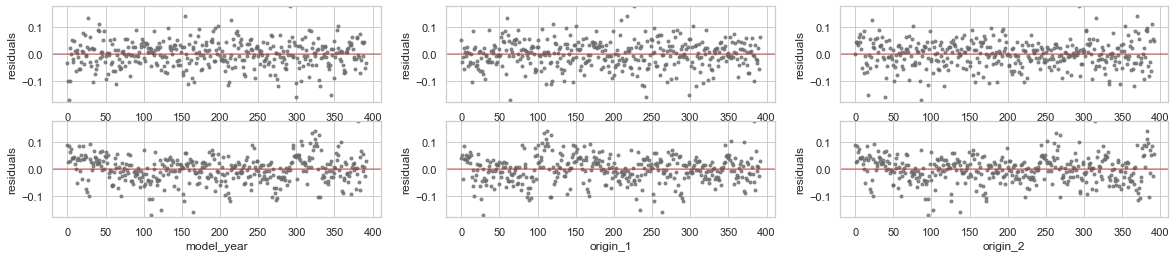

In [75]:
residuals1 = plot_residuals(result4, ["displacement", "weight", "acceleration", "model_year", "origin_1", "origin_2"])

The residual plots for each of the features in our model appear to have random scatter on either side of 0 which tells us that there does seem to be other transformations that we should do to the features.

Now, we will compare our predictions based on our domain knowledge to that of the actual values that we estimate, in terms of probabilities. We will use the function provided below. 

In [76]:
# {"var1": "+", "var2": "-"}
def evaluate_coefficient_predictions(predictions, result):
    coefficients = result["resampled_coefficients"].columns
    for coefficient in coefficients:
        if coefficient == 'intercept':
            continue
        if predictions[coefficient] == '+':
            print("{0} P(>0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] > 0)))
        else:
            print("{0} P(<0)={1:.3f}".format(coefficient, np.mean(result["resampled_coefficients"][coefficient] < 0)))

From our domain knowledge, we expect the features to have the following sings (+, -):

   - displacement : negative
   - weight : negative
   - acceleration : positive
   - model_year : positive
   - origin_1 : positive (from EDA)
   - origin_2 : positive (from EDA)
   - displacement:weight : unknown

In [77]:
predictions = {
    "displacement": '-',
    "weight": '-',
    "acceleration": '+',
    "model_year": '+',
    "origin_1": '+',
    "origin_2": '+',
    "displacement:weight": '+'}

evaluate_coefficient_predictions(predictions, result4)

displacement P(<0)=1.000
weight P(<0)=1.000
acceleration P(>0)=0.960
model_year P(>0)=1.000
origin_1 P(>0)=0.110
origin_2 P(>0)=0.860
displacement:weight P(>0)=1.000


We see that `displacement` and `weight` have a very high probability of being negative while `acceleration`, `model_year`, `origin_2`, and `displacement:weight` have a very high probability of being positive.

However, there is a very low probability that `origin_1` is positive. We need to check into this.

Let's remind ourselves of the credible intervals:

In [78]:
models.describe_bootstrap_lr(result4)

Since `acceleration` has an unexpected sign and the credible interval includes 0, we should remove it from our model.

`origin_1` has an unexpected sign and inclues 0, so we can remove it from our model as well. We will try adding `origin_3` instead.

Let's make another model with these changes.

In [79]:
result5 = models.bootstrap_linear_regression("log_mpg ~ displacement + weight + acceleration + model_year + origin_2 + origin_3 + displacement:weight", data)

In [80]:
models.describe_bootstrap_lr(result5)

We see that our $R^2$ value has not changed from our previous model. This model still captures about $89\%$ of the variability of `log_mpg`. 

Now, let's take a quick look at these risidual plots.

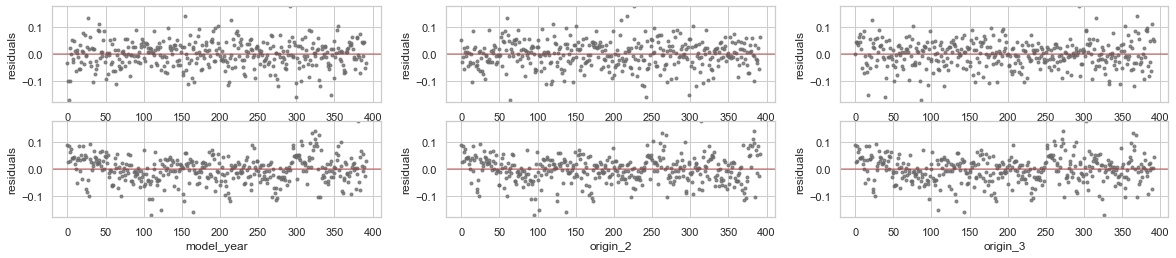

In [81]:
residuals2 = plot_residuals(result5, ["displacement", "weight", "acceleration", "model_year", "origin_2", "origin_3"])

We continue to see random scatter, so now let's look at our predicted signs.

In [82]:
predictions = {
    "displacement": '-',
    "weight": '-',
    "acceleration": '+',
    "model_year": '+',
    "origin_2": '+',
    "origin_3": '+',
    "displacement:weight": '+'}

evaluate_coefficient_predictions(predictions, result5)

displacement P(<0)=1.000
weight P(<0)=1.000
acceleration P(>0)=0.980
model_year P(>0)=1.000
origin_2 P(>0)=0.970
origin_3 P(>0)=0.890
displacement:weight P(>0)=1.000


Now, all of our signs have high probabilities of being what we would expect. So, we will keep all of these features in our model.

<a id="describe"></a>

## 1.4 - Describe the model

Our final model is presented again below:

In [83]:
models.describe_bootstrap_lr(result5)

In [84]:
adjusted_r_squared(result5)

0.8855785871511582

Notice that we have left `origin_1` out of the model. So, these values are represented by the intercept term.

This model has an $R^2$ value of $0.89$ and therefore captures about $89\%$ of the variability of `log_mpg`. The model has an adjusted $R^2$ value of $0.8856$, which is not very different from its $R^2$ value.

Each of the coefficients can be interpreted similar to

- The estimated value of $\beta o$ is 0.76, but there is a $95\%$ probability that the value is between $0.65$ and $0.89$. 

Additionally, we have credible bounds on the error of the regression ($\sigma$) as 0.04 to 0.05 and on the coefficient of determination ($R^2$) of $87\%$ to $91\%$.

<a id="use"></a>

## 1.5 - Use the model

In `result5`, we have stored all the Bootstrap estimates for the coefficients, and we therefore have enough information to do bootstrap estimates of the posterior distribution of prediction. We can use the function (from course material) to do this: 

In [85]:
def bootstrap_prediction(result, feature_values):
    # resampled_coefficients is a DataFrame in result.
    # each *row* is a different bootstrap model.
    # we use a Dict instead of Vector because the order may not be preserved.
    # we should modify this to use the model to pick the values and possibly
    # convert interactions terms.
    results = []
    for coefficients in result["resampled_coefficients"].itertuples():
        estimate = 0
        for feature in feature_values.keys():
            estimate += feature_values[feature] * getattr(coefficients, feature)
        results.append(estimate)
    return np.array(results)

Let's consider a vehicle that has the following information:

- displacement = 300
- weight = 3200
- acceleration = 12
- model_year = 76
- origin_2 = 1
- origin_3 = 0

What `mpg` would we predict that this vehicle gets? We can use our model to predict this value. After getting our prediction, we will need to convert back to `mpg` from `log_mpg`.

In [86]:
feature_values = {"intercept": 1, "displacement": 300, "weight": 3200, "acceleration": 12, "model_year": 76, "origin_2": 1, "origin_3": 0}
posterior_prediction = bootstrap_prediction(result5, feature_values)
posterior_prediction.mean()

1.0866676385957934

In [87]:
10 ** posterior_prediction.mean()

12.208649862902224

We would expect that this vehicle gets approximately $12.18$ `mpg`. We can also plot a histogram of the density of `log_mpg` for vehicles with the same information.

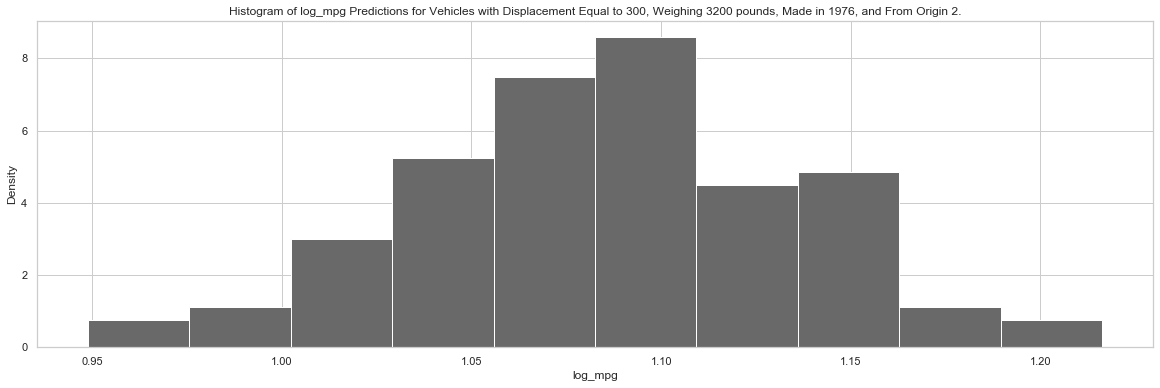

In [88]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(posterior_prediction, color="DimGray", density=True)
axes.set_xlabel( "log_mpg")
axes.set_ylabel( "Density")
axes.set_title("Histogram of log_mpg Predictions for Vehicles with Displacement Equal to 300, Weighing 3200 pounds, Made in 1976, and From Origin 2.")

plt.show()
plt.close()

We can also add error bounds to this prediction.

In [89]:
print("({0:.2f}, {1:.2f})".format(posterior_prediction.mean() - 2 * result5["sigma"], posterior_prediction.mean() + 2 * result5["sigma"]))

(0.99, 1.19)


So, for vehicles with this information, we would predict `log_mpg` of $1.08$ and the $95\%$ bounds would be $(0.98, 1.18)$ If we transform `log_mpg` back ingo `mpg`, the $95\%$ error bounds would be:

In [90]:
print("({0:.2f}, {1:.2f})".format(10 ** 0.98, 10 ** 1.18))

(9.55, 15.14)


Let's make another prediction.

Let's now consider a vehicle that has the following information:

- displacement = 275
- weight = 3000
- acceleration = 13
- model_year = 78
- origin_2 = 0
- origin_3 = 1

What `mpg` would we predict that this vehicle gets?

In [91]:
feature_values = {"intercept": 1, "displacement": 275, "weight": 3000, "acceleration": 13, "model_year": 78, "origin_2": 0, "origin_3": 1}
posterior_prediction = bootstrap_prediction(result5, feature_values)
posterior_prediction.mean()

1.1620349925100226

In [92]:
10 ** posterior_prediction.mean()

14.522286236276296

We would expect that this vehicle gets approximately $14.43$ `mpg`. The $95\%$ error bounds for `log_mpg` and `mpg`, respectively, are given below:

In [93]:
print("({0:.2f}, {1:.2f})".format(posterior_prediction.mean() - 2 * result5["sigma"], posterior_prediction.mean() + 2 * result5["sigma"]))

(1.06, 1.26)


In [94]:
print("({0:.2f}, {1:.2f})".format(10 ** 1.05, 10 ** 1.25))

(11.22, 17.78)
